In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from model import Model
from plot_utilities import plot_losses, plot_surface, plot_error
tf.keras.backend.set_floatx('float64')

In [20]:
# Set up the training and test data of the unit square domain
tf.random.set_seed(0)

N = 1000  # number of points in the domain
x = tf.random.uniform((N, 2), dtype=tf.float64)  # random values from a uniform distribution

# split data into training and test sets
x_train = x[:100]  # 100 points for training
x_test = x[100:]  # 900 points for testing

In [25]:
# Trial function that satisfies the boundary conditions by construction
def trial_fn(X, nn):
        x, y = tf.split(X, 2, axis=1)
        one = tf.constant(1., dtype=tf.float64)
        A = (1.-x)*y**3 + x*(1.+y**3)*tf.exp(-one) + (1.-y)*x*(tf.exp(-x) - tf.exp(-one)) \
            + y*((1.+x)*tf.exp(-x) - (1.-x+2*x*tf.exp(-one)))
        
        return A + x * (x-1) * y * (y-1) * nn(X)

# Loss function (Poisson equation)
def pde_lagaris(x, nn):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape1.watch(x)
            tape2.watch(x)
            u = trial_fn(x, nn)
        d_u = tape2.gradient(u, x)  # first derivatives (u_x, u_y)
    d2_u = tape1.batch_jacobian(d_u, x)  # Hessian matrix (u_xx, u_xy; u_yx, u_yy)

    u_xx = d2_u[:, 0, 0:1]
    u_yy = d2_u[:, 1, 1:2]
    f =  -tf.exp(-x[:, 0:1]) * (-2.+x[:, 0:1]+6.*x[:, 1:2]+x[:, 1:2]**3.)

    return tf.reduce_mean(tf.square(-u_xx - u_yy - f))

In [36]:
network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Input(shape=(2,)))
network.add(tf.keras.layers.Dense(10, activation='sigmoid'))
network.add(tf.keras.layers.Dense(1))
print(network.summary())

optimiser = tf.keras.optimizers.Adam(learning_rate=1e-3,)
model = Model(pde=pde_lagaris, net=network, optimiser=optimiser)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                30        
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41 (328.00 Byte)
Trainable params: 41 (328.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None


In [37]:
# Train the model
losses = model.train(x_train, num_epochs=20000, verbose=True)

Epoch 1000 -- Training loss: 0.0010700576344508422
Epoch 2000 -- Training loss: 0.00020931855653560764
Epoch 3000 -- Training loss: 0.00017414402699417989
Epoch 4000 -- Training loss: 0.00011922249179774527
Epoch 5000 -- Training loss: 5.325584673076809e-05
Epoch 6000 -- Training loss: 2.379988018674139e-05
Epoch 7000 -- Training loss: 1.8410131956338155e-05
Epoch 8000 -- Training loss: 1.2775536395150443e-05
Epoch 9000 -- Training loss: 5.455335158405092e-06
Epoch 10000 -- Training loss: 2.228949035544455e-06
Epoch 11000 -- Training loss: 1.1154696634616278e-06
Epoch 12000 -- Training loss: 6.389180433316587e-07
Epoch 13000 -- Training loss: 4.728036637582824e-07
Epoch 14000 -- Training loss: 4.840676421098468e-07
Epoch 15000 -- Training loss: 3.191427320944963e-07
Epoch 16000 -- Training loss: 2.6090973214573557e-07
Epoch 17000 -- Training loss: 2.1219107620283669e-07
Epoch 18000 -- Training loss: 1.7404172958822601e-07
Epoch 19000 -- Training loss: 1.4524973327756064e-07
Epoch 20000

Test loss: 1.7223053232409974e-07


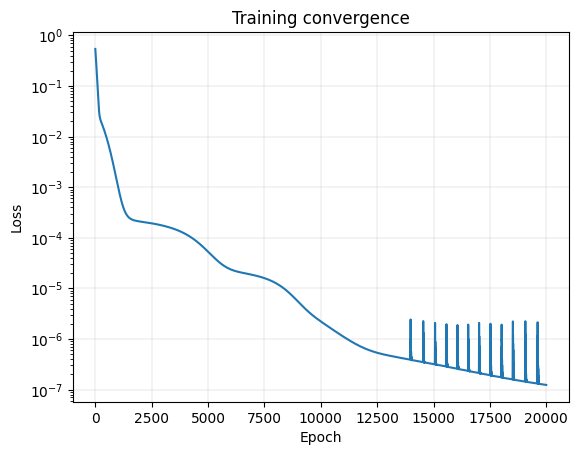

In [38]:
# Plot the convergence
fig, ax = plt.subplots()
ax.semilogy(np.arange(len(losses)), losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(linewidth=0.2)
ax.set_title('Training convergence')

# Test the trained model
test_loss = model.test(x_test)
print(f'Test loss: {test_loss}')

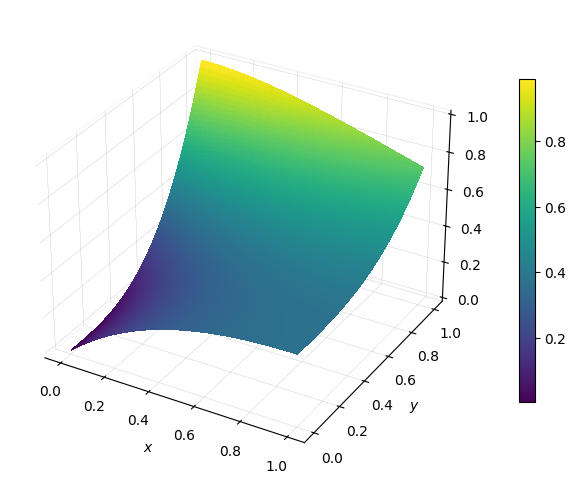

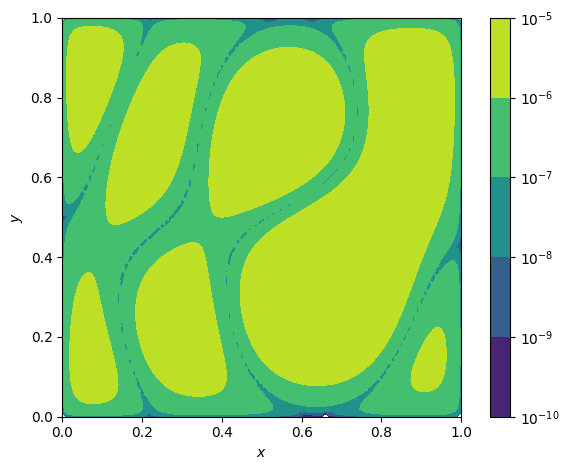

In [39]:
# Plot the solution on a fine uniform grid for aesthetic purposes
x_ = tf.linspace(0, 1, 101)
x_grid = tf.reshape(tf.stack(tf.meshgrid(x_, x_), axis=2), (-1, 2))

v = trial_fn(x_grid, model.net)
fig, _ = plot_surface(x_grid, v)
fig.savefig('figures/p3_lagaris_ex5_surf.png', dpi=300, bbox_inches='tight')

# Plot the absolute error of the trial solution and the analytical solution
u_analytical = lambda x, y: tf.exp(-x) * (x+y**3) 
fig, _ = plot_error(x_grid, v, u_analytical, title=False, levels=np.logspace(-10, -5, 6))
fig.savefig('figures/p3_lagaris_ex5_error.png', dpi=300, bbox_inches='tight')

In [15]:
# Now repeat the above but with incorrectly computed second derivatives,
# as done in https://github.com/PGrabinski/NeuralDifferentialEquations
# and https://github.com/Isaac-Somerville/Neural-Networks-for-Solving-Differential-Equations/tree/main

def pde_lagaris(x, nn):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape1.watch(x)
            tape2.watch(x)
            u = trial_fn(x, nn)
        d_u = tape2.gradient(u, x)  # first derivatives (u_x, u_y)
    d2_u = tape1.gradient(d_u, x)  # THIS IS WRONG! Does implicit summation: (u_xx + u_xy, u_yy + u_xy)

    u_xx = d2_u[:, 0:1]  # THIS IS WRONG! This is: u_xx + u_xy
    u_yy = d2_u[:, 1:2]  # THIS IS WRONG! This is: u_yy + u_xy
    f =  -tf.exp(-x[:, 0:1]) * (-2.+x[:, 0:1]+6.*x[:, 1:2]+x[:, 1:2]**3.)

    return tf.reduce_mean(tf.square(-u_xx - u_yy - f))

network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Input(shape=(2,)))
network.add(tf.keras.layers.Dense(10, activation='sigmoid'))
network.add(tf.keras.layers.Dense(1))

optimiser = tf.keras.optimizers.Adam(learning_rate=1e-3,)
model = Model(pde=pde_lagaris, net=network, optimiser=optimiser)

losses = model.train(x_train, num_epochs=25000, verbose=True)
test_loss = model.test(x_test)
print(f'Test loss: {test_loss}')

Epoch 1000 -- Training loss: 0.48498622745041414
Epoch 2000 -- Training loss: 0.40831855508011317
Epoch 3000 -- Training loss: 0.24922442457844324
Epoch 4000 -- Training loss: 0.15882286050915426
Epoch 5000 -- Training loss: 0.1376398029386084
Epoch 6000 -- Training loss: 0.11696969831634582
Epoch 7000 -- Training loss: 0.09367831208583668
Epoch 8000 -- Training loss: 0.0742823735502144
Epoch 9000 -- Training loss: 0.05922898801239983
Epoch 10000 -- Training loss: 0.04458223818415412
Epoch 11000 -- Training loss: 0.03196630627400304
Epoch 12000 -- Training loss: 0.025781021453035
Epoch 13000 -- Training loss: 0.021747862032844668
Epoch 14000 -- Training loss: 0.01862792188413438
Epoch 15000 -- Training loss: 0.01685512531675583
Epoch 16000 -- Training loss: 0.01575469956730853
Epoch 17000 -- Training loss: 0.014759355707388802
Epoch 18000 -- Training loss: 0.013677664432376635
Epoch 19000 -- Training loss: 0.012447362675320522
Epoch 20000 -- Training loss: 0.011408617708366493
Epoch 21

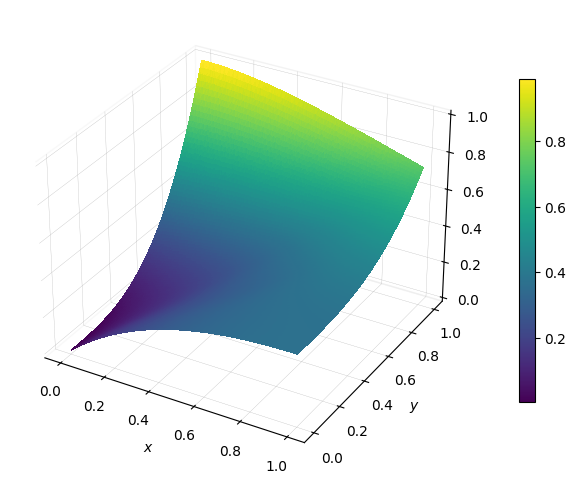

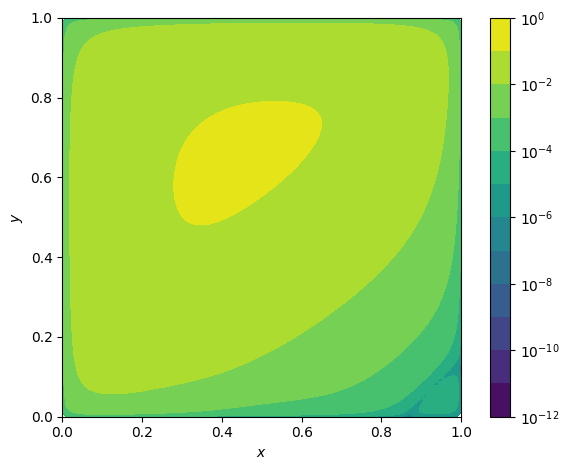

In [18]:
# Plot the solution on a fine uniform grid for aesthetic purposes
x_ = tf.linspace(0, 1, 101)
x_grid = tf.reshape(tf.stack(tf.meshgrid(x_, x_), axis=2), (-1, 2))

v = trial_fn(x_grid, model.net)
fig, _ = plot_surface(x_grid, v)
fig.savefig('figures/p3_lagaris_ex5_surf_wrong.png', dpi=300, bbox_inches='tight')

# Plot the absolute error of the trial solution and the analytical solution
u_analytical = lambda x, y: tf.exp(-x) * (x+y**3) 
fig, _ = plot_error(x_grid, v, u_analytical, title=False, levels=np.logspace(-12, 0, 13))
fig.savefig('figures/p3_lagaris_ex5_error_wrong.png', dpi=300, bbox_inches='tight')